# <font color='blue'>Introduction to Wavelets</font>

---

<img src="images/cea_logo.png" width="100" align="right">


> Author: **Samuel Farrens**

> Year: **2016**

> Version: **1.0**

> Email: **[samuel.farrens@cea.fr](mailto:samuel.farrens@cea.fr)**

> Web: **[CosmoStat Website](http://www.cosmostat.org/)**


## <font color='blue'>Contents</font>

---
 
1. [Set-Up](#Set-Up)
1. [Introduction](#Introduction)
1. [Fourier Domain](#Fourier-Domain)
 * [Discrete Fourier Transform](#Discrete-Fourier-Transform)
 * [Gabor Transform](#Gabor-Transform)
1. [Wavelets](#Wavelets)

## <font color='blue'>Set-Up</font>

---

Here we will import a couple of packages that we will need throughout the notebook.

In [1]:
# Tell Jupyter to display plots in this notebook.
%matplotlib inline

# Import the numpy package with the alias np.
import numpy as np           

# Import the pyplot package from matplotlib with the alias plt.
import matplotlib.pyplot as plt  
from matplotlib import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

# Import some tools from scipy.
from scipy import fftpack, signal

# Import time package.
import time

# SOME USEFUL FUNCTIONS

# Function to calculate an orthonormal descrete cosine transform.
def fft(signal):

    return fftpack.fft(signal)

# Function to calculate an orthonormal descrete cosine transform.
def ifft(signal):

    return fftpack.ifft(signal)

def hide_axes(axis):
    
    axis.xaxis.set_ticklabels([])
    axis.yaxis.set_ticklabels([])

## <font color='blue'>Introduction</font>

---



## <font color='blue'>Fourier Domain</font>

---

Most signals can be decomposed into a sum of sine and cosine waves.

### <font color='green'>Discrete Fourier Transform</font>

The Discrete Fourier Transform (DFT) can be represented as:

$$F[n] = \frac{1}{N} \sum_{k=0}^{N-1} f[k] e^{2\pi i kn/N}$$

where $N$ denotes the number of data points, and $n$ and $k$ represent the ordinals in the time and frequency domains respectively. The corresponding inverse function is:

$$f[k] = \sum_{n=0}^{N-1} F[n] e^{-2\pi i kn/N}$$

We can use this transform to extract frequency information from a given signal.

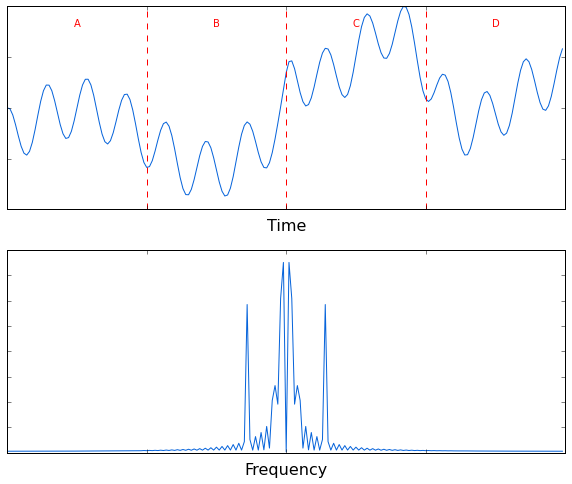

In [2]:
# Define the signal
n = np.linspace(-1, 1, 200, endpoint=False)
Fn  = np.cos(2 * np.pi * 7 * n) + signal.gausspulse(n - 0.4, fc=2) + np.sin(2 * np.pi * n) + np.tanh(2 * np.pi * 8 * n)
Fn /= max(abs(Fn))

# Get the Fourier transform of the signal
fk = np.abs(fftpack.fftshift(fft(Fn)))

# Display
ax1 = plt.subplot(211)
ax1.plot(n, Fn, '-', color='#0764DB')
ax1.plot([-0.5, -0.5], [-1, 1], 'r--')
ax1.plot([0.0, 0.0], [-1, 1], 'r--')
ax1.plot([0.5, 0.5], [-1, 1], 'r--')
plt.text(-0.76, 0.8, 'A', color='red')
plt.text(-0.26, 0.8, 'B', color='red')
plt.text(0.24, 0.8, 'C', color='red')
plt.text(0.74, 0.8, 'D', color='red')
ax1.set_xlabel('Time', fontsize=16)
hide_axes(ax1)
ax2 = plt.subplot(212)
ax2.plot(n, fk, '-', color='#0764DB')
ax2.set_xlabel('Frequency', fontsize=16)
hide_axes(ax2)
plt.show()

In doing so, however, we lose all of the time infotmation. We can try instead looking at the frequency information contained within smaller time intervals.

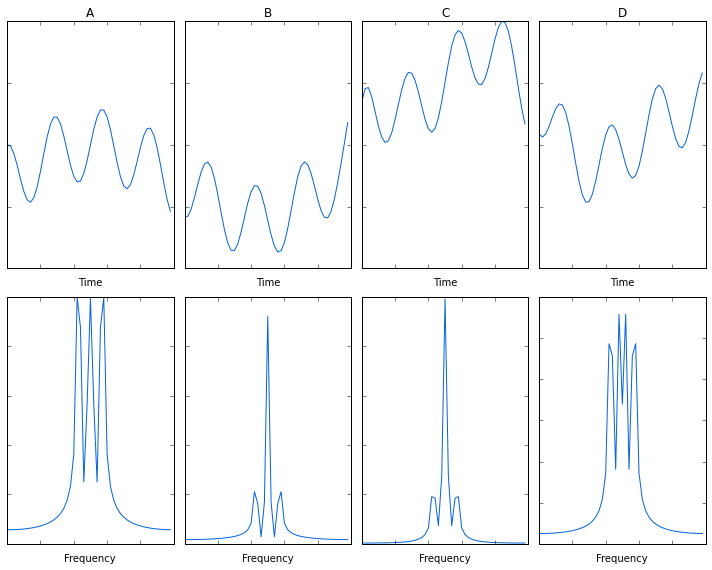

In [5]:
# Slice the signal into four pieces
slice_size = n.size / 4
slices = [slice(i * slice_size, (i + 1) * slice_size) for i in range(4)]
titles = ('A', 'B', 'C', 'D')

# Display
for i in range(len(slices)):
    fk_slice = np.abs(fftpack.fftshift(fft(Fn[slices[i]])))
    ax = plt.subplot(2, 4, i + 1)
    ax.plot(n[slices[i]], Fn[slices[i]], '-', color='#0764DB')
    ax.set_ylim(-1, 1)
    ax.set_xlabel('Time')
    ax.set_title(titles[i])
    hide_axes(ax)
    ax = plt.subplot(2, 4, i + 5)
    ax.plot(n[slices[i]], fk_slice, '-', color='#0764DB')
    ax.set_xlabel('Frequency')
    hide_axes(ax)
plt.tight_layout()
plt.show()

What happens if we make the windows smaller?

### <font color='green'>Uncertainty Principle</font>

The **Heisenberg–Gabor limit**, 

$$\Delta t \Delta \omega \geq \frac{1}{2},$$

an interpretation of the uncertainty principle, shows that it is not possible to simultaneously sharply localize a signal in both the time domain and frequency domain.

In other words we will always need to make a trade-off between time information and frequency information, but is the best way to preserve as much of both as possible?

### <font color='green'>Gabor Transform</font>

The Gabor transform or Short Time Fourier Transform (STFT) can be represented as:

$$f[m, k] = \sum_{n=0}^{N-1} F[n] g[n - m] e^{-2\pi i kn/N}$$

where $g$ is a filter localised at $m$. Effectively this performs a Fourier transform of the signal within the filter which is centred at $m$. 

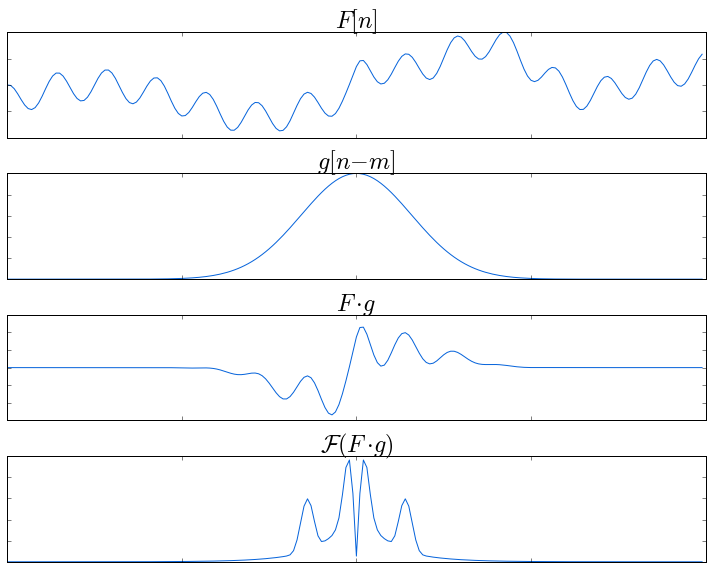

In [11]:
# Define a Gaussian filter.
def get_filter(m, w):

    return np.exp(-w * (n - m) ** 2)

# Set filter width.
width = 20

# Set filter position.
pos = 0.0

# Get localised filter.
g = get_filter(pos, width)

# Filter the signal.
Fg = Fn * g

# Get frequencies of filtered signal.
Fg_fft = np.abs(np.fft.fftshift(fft(Fg)))

# Display.
fig, ax = plt.subplots(4, 1)
ax[0].plot(n, Fn, '-', color='#0764DB')
ax[0].set_title('$F[n]$', fontsize=24)
ax[1].plot(n, g, '-', color='#0764DB')
ax[1].set_title('$g[n-m]$', fontsize=24)
ax[2].plot(n, Fg, '-', color='#0764DB')
ax[2].set_title('$F \cdot g$', fontsize=24)
ax[3].plot(n, Fg_fft, '-', color='#0764DB')
ax[3].set_title('$\mathcal{F}(F \cdot g)$', fontsize=24)
[hide_axes(i) for i in ax]
plt.tight_layout()
plt.show()


Try adjusting the filter width and position ($-1\leq m\leq 1$) and see what happens.

Now, to try to preserve some frequency and time information simultaneously we will slide the filter across the whole signal and store the frequencies at a set of intervals.

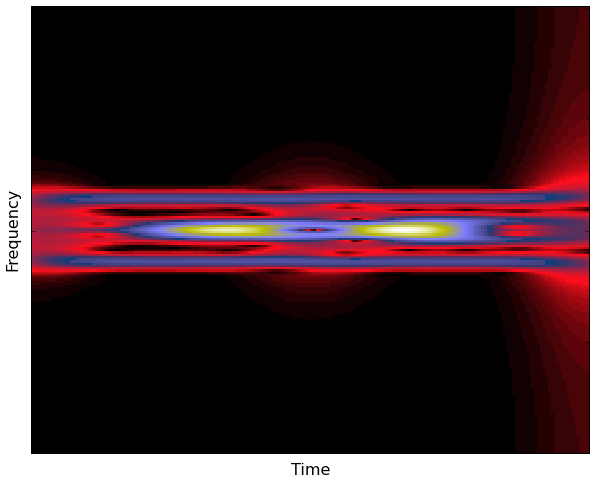

In [29]:
# Set interval size.
interval_size = 0.01

# Set a range of time intervals.
intervals = np.arange(-1, 1, interval_size)

# Get the FFT of the filtered signal at each interval.
w = []
for m in intervals:
    w.append(np.abs(np.fft.fftshift(fft(Fn * get_filter(m, width)))))
w = np.array(w).T

# Display
fig, ax = plt.subplots(1, 1)
ax.imshow(w, aspect='auto', interpolation='nearest', cmap='gist_stern')
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('Frequency', fontsize=16)
hide_axes(ax)
plt.show()

While we retain information in both time and frequency domains we also lose resolution.

## <font color='blue'>Wavelets</font>

---